In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
manager_data = pd.read_csv('https://raw.githubusercontent.com/keithmcnulty/ebp_exercise/master/data.csv', index_col = 'employee_id')

In [3]:
manager_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 571 entries, c4578853 to e81f635b
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   performance_group  571 non-null    object 
 1   yrs_employed       571 non-null    float64
 2   manager_hire       571 non-null    object 
 3   test_score         571 non-null    int64  
 4   group_size         571 non-null    int64  
 5   concern_flag       571 non-null    object 
 6   mobile_flag        571 non-null    object 
 7   customers          571 non-null    int64  
 8   high_hours_flag    571 non-null    object 
 9   transfers          571 non-null    int64  
 10  reduced_schedule   571 non-null    object 
 11  city               571 non-null    object 
dtypes: float64(1), int64(4), object(7)
memory usage: 58.0+ KB


In [4]:
manager_data.head()

,performance_group,yrs_employed,manager_hire,test_score,group_size,concern_flag,mobile_flag,customers,high_hours_flag,transfers,reduced_schedule,city
employee_id,,,,,,,,,,,,
c4578853,Bottom,4.6,N,205,10,N,N,12,N,0,Y,San Francisco
a7d7afd6,Middle,5.3,N,227,14,N,Y,18,N,0,N,New York
272b93f1,Bottom,5.2,N,227,10,N,N,12,N,0,Y,Chicago
be8b6baa,Middle,4.9,N,273,19,N,N,26,Y,0,N,New York
a18ecc4e,Bottom,4.9,N,227,17,Y,N,26,Y,5,Y,Orlando


<AxesSubplot:xlabel='performance_group', ylabel='count'>

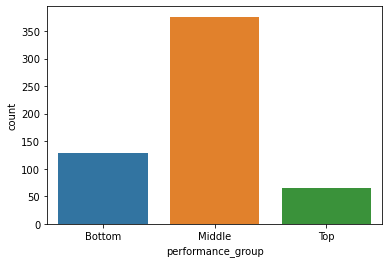

In [5]:
sns.countplot(data = manager_data, x = "performance_group")

In [6]:
## convert to binary bottom
binary_bottom = pd.get_dummies(manager_data['performance_group'])['Bottom']
binary_bottom.columnsumns = 'Bottom'

In [7]:
manager_data_bot = pd.concat([manager_data.drop('performance_group', axis = 1), binary_bottom], axis = 1)

In [8]:
## get dummies
dummy_vars = ['manager_hire', 'concern_flag', 
             'mobile_flag', 'high_hours_flag', 
             'reduced_schedule', 'city']

dummies = pd.get_dummies(manager_data_bot[dummy_vars], 
                         drop_first=True)


In [9]:
data = pd.concat([manager_data_bot.drop(dummy_vars, axis = 1), dummies], axis = 1)

In [10]:
X = data.drop('Bottom', axis = 1)
y = data['Bottom']

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [13]:
model = LogisticRegression(max_iter=1000)

In [14]:
X_train

,yrs_employed,test_score,group_size,customers,transfers,manager_hire_Y,concern_flag_Y,mobile_flag_Y,high_hours_flag_Y,reduced_schedule_Y,city_Houston,city_New York,city_Orlando,city_San Francisco,city_Toronto
employee_id,,,,,,,,,,,,,,,
07eb21de,5.3,205,11,28,3,0,1,1,1,0,0,0,1,0,0
01462797,4.6,167,17,26,3,0,0,0,1,0,0,1,0,0,0
15995879,4.6,273,13,22,0,0,0,0,0,0,0,1,0,0,0
c848bdb0,4.8,227,13,22,5,0,0,0,0,0,0,0,0,0,1
4d593345,4.5,136,6,22,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474567e,5.0,280,15,24,0,0,0,0,1,0,0,1,0,0,0
72a59199,5.0,379,10,30,0,0,0,1,1,0,0,1,0,0,0
bd135c46,4.4,303,11,20,2,0,0,1,0,1,0,1,0,0,0


In [15]:
y_train

employee_id
07eb21de    0
01462797    0
15995879    0
c848bdb0    1
4d593345    0
           ..
3474567e    0
72a59199    1
bd135c46    0
6fe8b754    0
0b5637d7    0
Name: Bottom, Length: 399, dtype: uint8

In [16]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [17]:
model.coef_

array([[ 0.69775197, -0.00390315, -0.06663276,  0.04878722,  0.0401337 ,
         1.02095618,  0.21141139,  0.2260984 , -0.47032329, -0.15182481,
         0.06351435, -0.32451692,  0.20757069,  0.81563256,  0.04609246]])

In [18]:
predicts = model.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
print(confusion_matrix(y_test, predicts))

[[128   2]
 [ 40   2]]


In [21]:
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       130
           1       0.50      0.05      0.09        42

    accuracy                           0.76       172
   macro avg       0.63      0.52      0.47       172
weighted avg       0.70      0.76      0.67       172



In [22]:
## scale for subsequent models

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [23]:
X_train = scaler.fit_transform(X_train)

In [24]:
X_test = scaler.transform(X_test)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []

for i in range(1, 40):
    modeli = KNeighborsClassifier(n_neighbors=i)
    modeli.fit(X_train, y_train)
    predicti = modeli.predict(X_test)
    error_rate.append(np.mean(predicti != y_test))

In [26]:
error_rate = pd.DataFrame(dict(k=range(1,40), err=error_rate))

<AxesSubplot:xlabel='k', ylabel='err'>

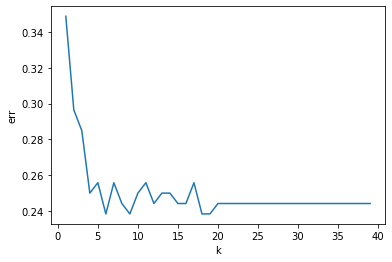

In [27]:
sns.lineplot(data = error_rate, x = 'k', y = 'err')

In [28]:
## k = 6 looks best

knnmodel = KNeighborsClassifier(n_neighbors=6)

In [29]:
knnmodel.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [30]:
knnpredicts = knnmodel.predict(X_test)

In [31]:
print(confusion_matrix(y_test, knnpredicts))

[[126   4]
 [ 37   5]]


In [32]:
print(classification_report(y_test, knnpredicts))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       130
           1       0.56      0.12      0.20        42

    accuracy                           0.76       172
   macro avg       0.66      0.54      0.53       172
weighted avg       0.72      0.76      0.70       172



In [33]:
## Basic decision Tree

from sklearn.tree import DecisionTreeClassifier
treemodel = DecisionTreeClassifier()

In [34]:
treemodel.fit(X_train, y_train)

DecisionTreeClassifier()

In [35]:
treepredicts = treemodel.predict(X_test)

In [36]:
print(confusion_matrix(y_test, treepredicts))

[[100  30]
 [ 30  12]]


In [37]:
print(classification_report(y_test, treepredicts))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       130
           1       0.29      0.29      0.29        42

    accuracy                           0.65       172
   macro avg       0.53      0.53      0.53       172
weighted avg       0.65      0.65      0.65       172



In [49]:
## random forest

from sklearn.ensemble import RandomForestClassifier
forestmodel = RandomForestClassifier(n_estimators=2000)

In [50]:
forestmodel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=2000)

In [51]:
forestpredicts = forestmodel.predict(X_test)

In [52]:
print((confusion_matrix(y_test, forestpredicts)))

[[123   7]
 [ 39   3]]


In [53]:
print((classification_report(y_test, forestpredicts)))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       130
           1       0.30      0.07      0.12        42

    accuracy                           0.73       172
   macro avg       0.53      0.51      0.48       172
weighted avg       0.65      0.73      0.66       172



In [54]:
from sklearn.svm import SVC

In [55]:
svmmodel = SVC()

In [56]:
svmmodel.fit(X_train, y_train)

SVC()

In [57]:
svmpredicts = svmmodel.predict(X_test)

In [58]:
print(confusion_matrix(y_test, svmpredicts))

[[128   2]
 [ 39   3]]


In [59]:
print((classification_report(y_test, svmpredicts)))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       130
           1       0.60      0.07      0.13        42

    accuracy                           0.76       172
   macro avg       0.68      0.53      0.49       172
weighted avg       0.73      0.76      0.68       172



In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [62]:
annmodel = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
annmodel.add(Dense(15,  activation='relu'))


# hidden layer
annmodel.add(Dense(5, activation='relu'))


# output layer
annmodel.add(Dense(units=1,activation='sigmoid'))

# Compile model
annmodel.compile(loss='binary_crossentropy', optimizer='adam')

In [63]:
annmodel.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          validation_data=(X_test, y_test) 
          )

Epoch 1/25
13/13 [==============================] - 0s 20ms/step - loss: 0.6468 - val_loss: 0.6123
Epoch 2/25
13/13 [==============================] - 0s 5ms/step - loss: 0.6261 - val_loss: 0.5946
Epoch 3/25
13/13 [==============================] - 0s 5ms/step - loss: 0.6079 - val_loss: 0.5798
Epoch 4/25
13/13 [==============================] - 0s 5ms/step - loss: 0.5922 - val_loss: 0.5666
Epoch 5/25
13/13 [==============================] - 0s 5ms/step - loss: 0.5773 - val_loss: 0.5560
Epoch 6/25
13/13 [==============================] - 0s 5ms/step - loss: 0.5650 - val_loss: 0.5470
Epoch 7/25
13/13 [==============================] - 0s 4ms/step - loss: 0.5540 - val_loss: 0.5399
Epoch 8/25
13/13 [==============================] - 0s 5ms/step - loss: 0.5446 - val_loss: 0.5338
Epoch 9/25
13/13 [==============================] - 0s 5ms/step - loss: 0.5362 - val_loss: 0.5297
Epoch 10/25
13/13 [==============================] - 0s 5ms/step - loss: 0.5287 - val_loss: 0.5267
Epoch 11/25
13/13 

In [64]:
annpredicts = annmodel.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [65]:
print(confusion_matrix(y_test, annpredicts))

[[127   3]
 [ 39   3]]


In [66]:
print(classification_report(y_test, annpredicts ))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       130
           1       0.50      0.07      0.12        42

    accuracy                           0.76       172
   macro avg       0.63      0.52      0.49       172
weighted avg       0.70      0.76      0.68       172



In [67]:
from xgboost import XGBClassifier

In [68]:
xgbmodel = XGBClassifier()

In [69]:
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
xgbpredicts = xgbmodel.predict(X_test)

In [71]:
print(confusion_matrix(y_test, xgbpredicts))

[[114  16]
 [ 29  13]]


In [72]:
print(classification_report(y_test, xgbpredicts))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       130
           1       0.45      0.31      0.37        42

    accuracy                           0.74       172
   macro avg       0.62      0.59      0.60       172
weighted avg       0.71      0.74      0.72       172

